<img src="https://gallery.mailchimp.com/f98d5ac0a3fbbdcdda35136ab/images/2002af76-5fd4-4185-9d49-28558b6b8772.png">

# `sg-hdb-resale-abr` 
# Part 2: Model Training
What we have done so far is to extract data from the .csv files, do some preliminary transformation to the data, and then loading all of it into an SQLite database. The next step is to work towards creating a simple predictive model for us to predict the price of a resale HDB unit. The following cells will have us load data from the SQLite database, that we have previously created.

In [1]:
# Import relevant packages
import pandas as pd
from sqlalchemy import create_engine

In [2]:
# Initialise engine
engine = create_engine('sqlite:///../data/processed/sg_hdb.db')

# Simple query to get the whole table
query = "SELECT * FROM sg_hdb_resale"

# Store result of query in a pandas dataframe
df = pd.read_sql_query(query, engine)

In [3]:
# Observe result of query executed
df

,id,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,town
0,1,309,improved,1 ROOM,31.0,1977,1990-01,0,9000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO
1,2,309,improved,1 ROOM,31.0,1977,1990-01,0,6000.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO
2,3,309,improved,1 ROOM,31.0,1977,1990-01,0,8000.0,10 TO 12,ANG MO KIO AVE 1,ANG MO KIO
3,4,309,improved,1 ROOM,31.0,1977,1990-01,0,6000.0,07 TO 09,ANG MO KIO AVE 1,ANG MO KIO
4,5,216,new generation,3 ROOM,73.0,1976,1990-01,0,47200.0,04 TO 06,ANG MO KIO AVE 1,ANG MO KIO
...,...,...,...,...,...,...,...,...,...,...,...,...
790638,790639,816,improved,5 ROOM,122.0,1988,2014-12,0,580000.0,10 TO 12,YISHUN ST 81,YISHUN
790639,790640,325,maisonette,EXECUTIVE,146.0,1988,2014-12,0,540000.0,10 TO 12,YISHUN CTRL,YISHUN
790640,790641,618,apartment,EXECUTIVE,164.0,1992,2014-12,0,738000.0,07 TO 09,YISHUN RING RD,YISHUN
790641,790642,277,maisonette,EXECUTIVE,152.0,1985,2014-12,0,592000.0,07 TO 09,YISHUN ST 22,YISHUN


We are first going to inspect the data types of the imported dataframe.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790643 entries, 0 to 790642
Data columns (total 12 columns):
id                     790643 non-null int64
block                  790643 non-null object
flat_model             790643 non-null object
flat_type              790643 non-null object
floor_area_sqm         790643 non-null float64
lease_commence_date    790643 non-null int64
month                  790643 non-null object
remaining_lease        790643 non-null int64
resale_price           790643 non-null float64
storey_range           790643 non-null object
street_name            790643 non-null object
town                   790643 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 72.4+ MB


Now, we create 2 separate series containing the predictor and response values to train our model on.

In [14]:
sg_hdb_x = df['floor_area_sqm'].values
sg_hdb_y = df['resale_price'].values

In [15]:
# Import the relevant packages
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from matplotlib import pyplot as plt

When training a model, we have to create a train-test split to check the accuracy/performance of the model.

In [16]:
sg_hdb_x_train, sg_hdb_x_test, sg_hdb_y_train, sg_hdb_y_test = sklearn.model_selection.train_test_split(
    sg_hdb_x, sg_hdb_y,
    test_size=0.3, random_state=7
)



In [17]:
# Reshaping needed when using a single variable for predictor
sg_hdb_x_train = sg_hdb_x_train.reshape(-1,1)
sg_hdb_x_test = sg_hdb_x_test.reshape(-1,1)


We are gonna create a simple linear regression model (a.k.a best fit line) from the dataset.

In [18]:
# Initialise model
lm = LinearRegression()

# Create model from the train sets
lm.fit(sg_hdb_x_train, sg_hdb_y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
# To observe the model's coefficients
print('Coefficients: \n X:', lm.coef_,'\n c:', lm.intercept_)


Coefficients: 
 X: [3518.48113445] 
 c: -49415.00329505594


Y = mX + C

After creating the model, we are going to evaluate its performance by pitting it against the test set.

First, we use the linear model to provide us with the predictions derived from the values in the test set.

In [20]:
sg_hdb_y_pred = lm.predict(sg_hdb_x_test)
sg_hdb_y_pred


array([186323.23271299, 217989.56292303, 179286.2704441 , ...,
       376321.21397321, 316507.03468759, 207434.11951968])

Thereafter, we are going to calculate the errors, pitting the predicted values with actual historical values.

In [21]:
# Examine fitness of model
r2_score(sg_hdb_y_test, sg_hdb_y_pred)


0.3994763162246405

Why does the model have such a score? Well, let's check how the linear model was created.

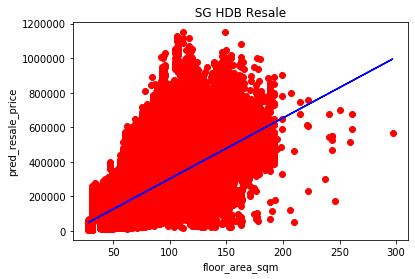

In [22]:
plt.scatter(sg_hdb_x_test, sg_hdb_y_test, color='red')
plt.plot(sg_hdb_x_test, sg_hdb_y_pred, color='blue')
plt.title(" SG HDB Resale ")
plt.xlabel('floor_area_sqm')
plt.ylabel("pred_resale_price")
plt.show()






A heavily sparsed set of data points can hardly be described by a single linear regression model, hence the low value of fitness.

For the sake of this exercise, let us just proceed and export (serialise) this model for deployment. Save the model under a name, for example like the one below: 'sg_hdb_lm_v1.pkl'

In [23]:
# Specify output location of model to be serialised
file_loc_name = '../models/sg_hdb_lm_v1.pkl'
pickle.dump(lm, open(file_loc_name, 'wb'))


Here, we just do a quick test by loading the model and then doing a single prediction to it.

In [24]:
# Test loading saved model
loaded_model = pickle.load(open(file_loc_name, 'rb'))
# Create a test value for test prediction
# Test value has to be contained in a numpy array format hence np.array
test_val = np.array(63)
# Reshaping value before feeding to .predict function
test_val_reshape = test_val.reshape(-1, 1)
# Conduct prediction
result = loaded_model.predict(test_val_reshape)
# Print out result
print(result)

[172249.3081752]


Now that we have exported this model, time to create a simple API (Application Programming Interface) that allows us to use the model, potentially remotely. On to [deployment](./sg-hdb-part3-basic-deployment.ipynb)!